###**Descrição da ponderada:**

Objetivo: Otimizar um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito. Aplicar técnicas avançadas de ajuste fino de hiperparâmetros, como grid search e random search, com o objetivo de aprimorar as métricas de desempenho do modelo, incluindo precisão, recall, F1-score e AUC-ROC. A atividade também exige uma comparação entre o modelo otimizado e o modelo original, permitindo avaliar o impacto das modificações nos hiperparâmetros sobre o desempenho geral.

In [4]:
%pip install gdown
import gdown

In [5]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=ab881cc9-6ed1-4365-8e35-c1504b40aaed
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 52.4MB/s]


'dataset.csv'

## Instalação e imports

In [6]:
!pip -q install scikeras imbalanced-learn --upgrade

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

from scikeras.wrappers import KerasClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [7]:
df = pd.read_csv("dataset.csv")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Daqui pra frente é o pré processamento ...

## Preparação de features

In [11]:
# Alvo dataset:
target_col = "Class"
assert target_col in df.columns, f"Coluna-alvo '{target_col}' não encontrada. Colunas: {df.columns.tolist()}"

# Remover colunas pouco úteis ou não normalizadas que atrapalham (Time)
drop_cols = [c for c in ["Time"] if c in df.columns]

X = df.drop(columns=[target_col] + drop_cols, errors="ignore")
y = df[target_col].astype(int)

# Sanidade: para o alvo binário
assert set(np.unique(y)).issubset({0, 1}), "A coluna alvo precisa ser binária (0/1)."

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Pesos de classe para desbalanceamento
classes = np.array([0, 1])
class_weights_values = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)
CLASS_WEIGHT = {int(k): float(v) for k, v in zip(classes, class_weights_values)}
print("Class weights:", CLASS_WEIGHT)

# Kwargs de treino
FIT_KW = {
    "clf__validation_split": 0.1,
    "clf__class_weight": CLASS_WEIGHT,
}

Class weights: {0: 0.5008661206149896, 1: 289.14340101522845}


In [12]:
# Pré-processamento: imputação + padronização das features numéricas
numeric_selector = make_column_selector(dtype_include=np.number)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_selector),
    ],
    remainder="drop"
)

def build_mlp(meta,
              hidden_layers=2,
              units=64,
              dropout=0.2,
              l2=1e-4,
              learning_rate=1e-3):
    """Usa 'meta' do SciKeras para obter n_features após o preprocess."""
    input_dim = meta["n_features_in_"]
    model = keras.Sequential(name="mlp_fraud")
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(layers.Dense(units, activation="relu",
                               kernel_regularizer=regularizers.l2(l2)))
        model.add(layers.BatchNormalization())
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"),
                 keras.metrics.Precision(name="prec"),
                 keras.metrics.Recall(name="rec")]
    )
    return model

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", factor=0.5, patience=3, mode="max", min_lr=1e-6
)

baseline_clf = KerasClassifier(
    model=build_mlp,
    # hiperparâmetros baseline:
    model__hidden_layers=2,
    model__units=64,
    model__dropout=0.2,
    model__l2=1e-4,
    model__learning_rate=1e-3,
    epochs=30,
    batch_size=512,
    verbose=0,
    callbacks=[early_stop, reduce_lr],
)

baseline_pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", baseline_clf),
])

## Modelo baseline (MLP) + avaliação

In [13]:
# Treino baseline
baseline_pipe.fit(X_train, y_train, **FIT_KW)

# Avaliação
def proba_pos(p):
    p = np.asarray(p)
    if p.ndim == 2 and p.shape[1] == 2:
        return p[:, 1]
    return p.ravel()

def evaluate(pipe, X, y, name="model"):
    # Tentativa padrão via Pipeline.predict_proba
    try:
        y_proba = proba_pos(pipe.predict_proba(X))
    except Exception as e:
        # Fallback: transforma manualmente e usa o estimador final
        try:
            Xt = pipe.named_steps["preprocess"].transform(X)
            y_proba = proba_pos(pipe.named_steps["clf"].predict_proba(Xt))
            print(f"[Aviso] Fallback do predict_proba do Pipeline → estimador direto ({type(e).__name__}: {e})")
        except Exception as e2:
            raise e2  # re-levanta se nem o fallback funcionar

    y_pred  = (y_proba >= 0.5).astype(int)

    auc  = roc_auc_score(y, y_proba)
    pre  = precision_score(y, y_pred, zero_division=0)
    rec  = recall_score(y, y_pred, zero_division=0)
    f1   = f1_score(y, y_pred, zero_division=0)
    cm   = confusion_matrix(y, y_pred)

    print(f"\n=== {name} ===")
    print(f"AUC-ROC : {auc:.4f}")
    print(f"Precisão: {pre:.4f}")
    print(f"Recall  : {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nMatriz de confusão (verdadeiro x predito):\n", cm)
    print("\nRelatório de classificação:\n", classification_report(y, y_pred, digits=4, zero_division=0))

    fpr, tpr, _ = roc_curve(y, y_proba)
    prec, rec_, _ = precision_recall_curve(y, y_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC - {name}")
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.plot(rec_, prec, label=f"{name}")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(f"Precision-Recall - {name}")
    plt.legend(loc="lower left")
    plt.show()

    return {"model": name, "auc": auc, "precision": pre, "recall": rec, "f1": f1}

[Aviso] Fallback do predict_proba do Pipeline → estimador direto (AttributeError: 'super' object has no attribute '__sklearn_tags__')

=== Baseline ===
AUC-ROC : 0.9778
Precisão: 0.0585
Recall  : 0.9184
F1-score: 0.1100

Matriz de confusão (verdadeiro x predito):
 [[55416  1448]
 [    8    90]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9745    0.9870     56864
           1     0.0585    0.9184    0.1100        98

    accuracy                         0.9744     56962
   macro avg     0.5292    0.9465    0.5485     56962
weighted avg     0.9982    0.9744    0.9855     56962



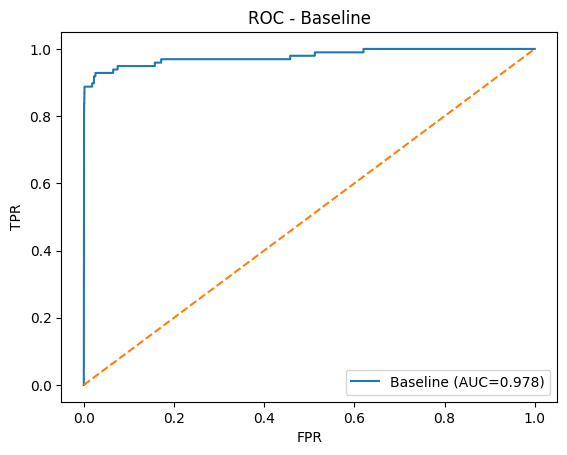

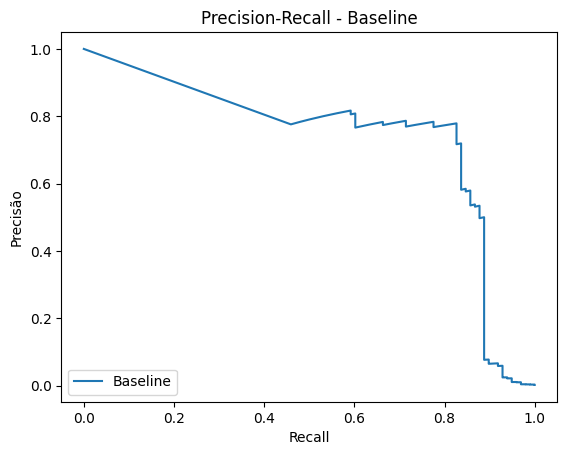

In [14]:
baseline_metrics = evaluate(baseline_pipe, X_test, y_test, name="Baseline")

## Interpretação dos resultados

* **AUC-ROC = 0.9778 (alta)**
  O modelo ranqueia muito bem as transações: em média, coloca as fraudes acima das não-fraudes. A curva ROC perto do canto superior-esquerdo confirma isso.
* **Recall = 0.9184 (muito alto)**
  Ele encontra **90 de 98** fraudes no teste. Só **8** passam batidas (FN).
* **Precisão = 0.0585 (muito baixa)**
  De cada 100 alertas, **\~6** são fraudes de verdade. Há **1.448 falsos positivos (FP)** contra **90 verdadeiros positivos (TP)**.
  Isso acontece porque a **base é extremamente desbalanceada** (fraude ≈ **0,17%** no teste: 98/56.962). Mesmo um **FPR pequeno (\~2,55%)** vira muitos FP.
* **F1 = 0.1100 (baixo)**
  F1 cai porque a precisão é muito baixa (F1 sendo o “meio-termo” entre precisão e recall).
* **Acurácia = 0.9744 (enganosa)**
  Em bases tão desbalanceadas, como é o caso aqui, acurácia não é útil: um modelo “sempre 0” teria **\~99,83%** de acurácia aqui — e ainda assim não detectaria nenhuma fraude.

## Confusão em números

* **TN = 55.416** | **FP = 1.448** → **FPR ≈ 2,55%**
* **FN = 8** | **TP = 90** → **Recall ≈ 91,84%**
* Só que **Precision = 90 / (90 + 1.448) ≈ 5,85%**

## Curvas

* **ROC alta**: separabilidade boa (AUC \~0,978).
* **Precision-Recall**: cai conforme se busca mais recall.
  No threshold padrão (0,5), o modelo está numa região de **recall alto** com **precisão muito baixa**; subir o threshold pode melhorar a precisão mas diminui recall (trade-off).

## Conclusão do baseline

* O modelo está bem calibrado para capturar fraudes (recall alto) à custa de muitos falsos positivos, o que dilui a precisão.
* Isso não é um erro do modelo, e sim uma consequência do desbalanceamento da base e threshold escolhido.


## Random Search

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

def _safe_predict_proba_from_pipeline(pipeline, X):
    """Tenta pipeline.predict_proba; se falhar, aplica preprocess e chama o clf.predict_proba."""
    try:
        proba = pipeline.predict_proba(X)
    except Exception:
        Xt = pipeline.named_steps["preprocess"].transform(X)
        proba = pipeline.named_steps["clf"].predict_proba(Xt)
    proba = np.asarray(proba)
    return proba[:, 1] if proba.ndim == 2 and proba.shape[1] == 2 else proba.ravel()

def safe_auc_scorer(estimator, X, y):
    """Scorer de AUC robusto para CV com SciKeras + Pipeline."""
    y_proba = _safe_predict_proba_from_pipeline(estimator, X)
    return roc_auc_score(y, y_proba)

def stratified_subsample(X, y, max_samples=60000, random_state=42):
    """Retorna um subset estratificado de até max_samples sem quebrar a proporção das classes."""
    n = len(y)
    if n <= max_samples:
        return X, y
    frac = max_samples / n
    sss = StratifiedShuffleSplit(n_splits=1, train_size=frac, random_state=random_state)
    idx, _ = next(sss.split(np.zeros(n), y))
    return X.iloc[idx], y.iloc[idx]

In [16]:
from scipy.stats import loguniform, randint
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras

# subset para acelerar a busca (com o dataset inteiro não estava rodando)
MAX_SAMPLES_FOR_SEARCH = 60000
X_rs, y_rs = stratified_subsample(X_train, y_train, max_samples=MAX_SAMPLES_FOR_SEARCH, random_state=SEED)

early_stop_search = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=2, mode="max", restore_best_weights=True, min_delta=1e-4
)
reduce_lr_search = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", factor=0.5, patience=1, mode="max", min_lr=1e-6
)

# estimador + pipeline
base_clf = KerasClassifier(
    model=build_mlp,
    callbacks=[early_stop_search, reduce_lr_search],
)

pipe_rs = Pipeline([
    ("preprocess", preprocess),
    ("clf", base_clf),
])

param_distributions = {
    "clf__model__hidden_layers": randint(1, 4),      # 1..3
    "clf__model__units": randint(32, 129),           # 32..128
    "clf__model__dropout": [0.0, 0.1, 0.2, 0.3, 0.4],
    "clf__model__l2": [0.0, 1e-5, 1e-4, 1e-3],
    "clf__model__learning_rate": loguniform(3e-5, 3e-3),
    "clf__batch_size": [512, 1024],
    "clf__epochs": [15, 20],
}

# CV curto p/ velocidade
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)

rs = RandomizedSearchCV(
    estimator=pipe_rs,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=safe_auc_scorer,
    refit=True,
    cv=cv,
    verbose=1,
    n_jobs=1,
    random_state=SEED,
)

rs.fit(X_rs, y_rs, **{**FIT_KW, "clf__validation_split": 0.1})

print("\n=== Random Search: melhores hiperparâmetros ===")
print(rs.best_params_)
print(f"Melhor AUC-ROC (CV, subset): {rs.best_score_:.4f}")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - auc: 0.3844 - loss: 1.7655 - prec: 0.0011 - rec: 0.3341 - val_auc: 0.8815 - val_loss: 0.6940 - val_prec: 0.0045 - val_rec: 0.8333 - learning_rate: 0.0011
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - auc: 0.8183 - loss: 0.7068 - prec: 0.0031 - rec: 0.8572 - val_auc: 0.9795 - val_loss: 0.5581 - val_prec: 0.0146 - val_rec: 0.8333 - learning_rate: 0.0011
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.8422 - loss: 0.5657 - prec: 0.0035 - rec: 0.8228 - val_auc: 0.9907 - val_loss: 0.4337 - val_prec: 0.0319 - val_rec: 1.0000 - learning_rate: 0.0011
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.9165 - loss: 0.4280 - prec: 0.0046 - rec: 0.8837 - val_auc: 0.9937 - val_loss: 0.3324 - val_prec: 0.0531 - val_rec: 1.0000 - learning_rate: 0.0011
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.9246 - loss: 0.3840 - prec: 0.0056 - rec: 0.8725 - va

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

best_rs = rs.best_params_

def around_units(u):
    c = int(u)
    return sorted(set([max(16, c//2), c, min(256, c*2)]))

def around_float(v, low=1e-5, high=1e-2):
    return sorted(set([max(low, v/2), v, min(high, v*2)]))

grid_params = {
    "clf__model__hidden_layers": [max(1, best_rs["clf__model__hidden_layers"]-1),
                                  best_rs["clf__model__hidden_layers"],
                                  min(4, best_rs["clf__model__hidden_layers"]+1)],
    "clf__model__units": around_units(best_rs["clf__model__units"]),
    "clf__model__dropout": [max(0.0, best_rs["clf__model__dropout"]-0.1),
                            best_rs["clf__model__dropout"],
                            min(0.5, best_rs["clf__model__dropout"]+0.1)],
    "clf__model__l2": sorted(set([
        best_rs["clf__model__l2"]/10 if best_rs["clf__model__l2"]>0 else 0.0,
        best_rs["clf__model__l2"],
        best_rs["clf__model__l2"]*10 if best_rs["clf__model__l2"]>0 else 1e-5
    ])),
    "clf__model__learning_rate": around_float(best_rs["clf__model__learning_rate"], low=1e-5, high=1e-2),
    "clf__batch_size": sorted(set([max(256, best_rs["clf__batch_size"]//2),
                                   best_rs["clf__batch_size"],
                                   min(2048, best_rs["clf__batch_size"]*2)])),
    "clf__epochs": sorted(set([max(12, best_rs["clf__epochs"]-5),
                               best_rs["clf__epochs"],
                               min(30, best_rs["clf__epochs"]+5)])),
}

base_clf2 = KerasClassifier(
    model=build_mlp,
    verbose=0,
    callbacks=[early_stop_search, reduce_lr_search],  # callbacks rápidos também no grid
)

pipe_gs = Pipeline([
    ("preprocess", preprocess),
    ("clf", base_clf2),
])

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)  # igual ao RS

gs = GridSearchCV(
    estimator=pipe_gs,
    param_grid=grid_params,
    scoring=safe_auc_scorer,
    refit=True,
    cv=cv,
    verbose=1,
    n_jobs=1,
)

gs.fit(X_rs, y_rs, **{**FIT_KW, "clf__validation_split": 0.1})

print("\n Grid Search: melhores hiperparâmetros")
print(gs.best_params_)
print(f"Melhor AUC-ROC (CV, subset): {gs.best_score_:.4f}")

Fitting 2 folds for each of 2187 candidates, totalling 4374 fits


## Avaliação final - Comparação e Análise

In [ ]:
#early stopping normal para o treino final
early_stop_final = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True, min_delta=1e-4
)
reduce_lr_final = keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", factor=0.5, patience=2, mode="max", min_lr=1e-6
)

best_pipe = gs.best_estimator_
best_pipe.set_params(clf__callbacks=[early_stop_final, reduce_lr_final])

# Treino FINAL no treino COMPLETO
best_pipe.fit(X_train, y_train, **FIT_KW)

# Métricas no TESTE do modelo otimizado
tuned_metrics = evaluate(best_pipe, X_test, y_test, name="Otimizado (Random+Grid rápido)")

# Comparação lado a lado
comparison = pd.DataFrame([baseline_metrics, tuned_metrics]).set_index("model")
print("\n Comparação (Baseline vs Otimizado)")
display(comparison)

# Ganhos absolutos
improve = {
    "AUC-ROC": tuned_metrics["auc"] - baseline_metrics["auc"],
    "Precisão": tuned_metrics["precision"] - baseline_metrics["precision"],
    "Recall": tuned_metrics["recall"] - baseline_metrics["recall"],
    "F1-score": tuned_metrics["f1"] - baseline_metrics["f1"],
}
print("\n Ganho (Otimizado - Baseline)")
for k, v in improve.items():
    print(f"{k}: {v:+.4f}")

# Análise curta
print("\n Análise")
msgs = []
if improve["AUC-ROC"] > 0:
    msgs.append(f"A separabilidade melhorou (ΔAUC={improve['AUC-ROC']:+.4f}).")
else:
    msgs.append(f"A separabilidade não melhorou (ΔAUC={improve['AUC-ROC']:+.4f}).")

if improve["Precisão"] > 0 and improve["Recall"] >= -0.01:
    msgs.append("Ganho de precisão sem queda relevante de recall.")
elif improve["Precisão"] > 0 and improve["Recall"] < -0.01:
    msgs.append("Precisão subiu com alguma queda de recall (trade-off).")
elif improve["Precisão"] <= 0 and improve["Recall"] > 0:
    msgs.append("Recall subiu mas a precisão caiu (mais FP).")
else:
    msgs.append("Sem melhora clara — amplie o espaço de busca ou ajuste o limiar de decisão.")

if improve["F1-score"] > 0:
    msgs.append(f"O F1 (equilíbrio P/R) melhorou (ΔF1={improve['F1-score']:+.4f}).")
else:
    msgs.append(f"O F1 não melhorou (ΔF1={improve['F1-score']:+.4f}).")

print(" ".join(msgs))